<a href="https://colab.research.google.com/github/atahanoezer/Wind/blob/main/Notebooks/Kelmarsh_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_absolute_percentage_error
from catboost import CatBoostRegressor

In [3]:
# Do this if you are using the datasets from your drive
from google.colab import drive
drive.mount('/content/drive/'
)

Mounted at /content/drive/


In [4]:
! git clone https://github.com/atahanoezer/Wind.git

Cloning into 'Wind'...
remote: Enumerating objects: 209, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 209 (delta 85), reused 139 (delta 39), pack-reused 0
Receiving objects: 100% (209/209), 18.63 MiB | 15.80 MiB/s, done.
Resolving deltas: 100% (85/85), done.


In [5]:
from Wind.dataset import Dataset
from Wind.utils import score_function
from Wind.model import *

In [6]:
import warnings
warnings.filterwarnings('ignore') # to avoid catboost and pd warnings

# Data Preprocess

In [7]:
# Change directory to the dataset
csv_name= '/content/drive/MyDrive/MLSES/datasets/Eng/Kelmarsh_SCADA_2020_3086/Turbine_Data_Kelmarsh_2_2020-01-01_-_2021-01-01_229.csv'
csv_params = {'index_col':'# Date and time','parse_dates':True,'skiprows':9} # This part is copied from data provider check references
df = pd.read_csv(csv_name,**csv_params)

# Change directory to the dataset
test_csv_name = '/content/drive/MyDrive/MLSES/datasets/Eng/Kelmarsh_SCADA_2021_3087/Turbine_Data_Kelmarsh_2_2021-01-01_-_2021-07-01_229.csv'
csv_params = {'index_col':'# Date and time','parse_dates':True,'skiprows':9}# This part is copied from data provider check references
test_df = pd.read_csv(csv_name,**csv_params)

concatenated_df = pd.concat([df, test_df]) # Concatanate test and train data
test_split = len(test_df)/len(concatenated_df)

In [8]:
# This part is also copied from data provider, fields look good in terms of statistics
use_columns = [ 'Wind speed (m/s)','Wind speed, Standard deviation (m/s)', 'Wind speed, Minimum (m/s)',
            'Wind speed, Maximum (m/s)','Wind direction (°)','Nacelle position (°)','Energy Export (kWh)','Power (kW)',
            'Reactive power (kvar)','Rotor speed (RPM)','Generator RPM (RPM)','Nacelle ambient temperature (°C)',
            'Blade angle (pitch position) A (°)','Blade angle (pitch position) B (°)','Blade angle (pitch position) C (°)',
            'Lost Production to Curtailment (Total) (kWh)','Lost Production to Downtime (kWh)','Metal particle count counter',
            'Front bearing temperature (°C)','Rear bearing temperature (°C)']

In [9]:
roll_window = 4
dataset = Dataset(concatenated_df[use_columns])
dataset.fill_nan(use_columns)
dataset.add_seasonal_feat(dataset.df, dataset.df.index)
# Rolling means selected heuristicly
dataset.apply_rolling_window(dataset.df,'Wind speed (m/s)', roll_window,np.mean)
dataset.apply_rolling_window(dataset.df,'Nacelle ambient temperature (°C)', roll_window,np.mean)
dataset.apply_rolling_window(dataset.df,'Generator RPM (RPM)' , roll_window,np.mean)

# Modelling



## Next Step Prediction



In [10]:
horizon = 1
window = 144

train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     window, horizon,target_col = 'Power (kW)',test_split= test_split)


In [11]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
model.train(train_x, train_y, val_x, val_y)

Learning rate set to 0.090136
0:	learn: 658.2993070	test: 617.5107374	best: 617.5107374 (0)	total: 43.2ms	remaining: 43.1s
500:	learn: 133.5310279	test: 170.1414318	best: 152.0016628 (60)	total: 13.4s	remaining: 13.4s
999:	learn: 127.5813940	test: 176.1983866	best: 152.0016628 (60)	total: 25s	remaining: 0us
bestTest = 152.0016628
bestIteration = 60
Shrink model to first 61 iterations.


                   MAE        RMSE        R2
Validation  102.938134  152.001660  0.948844
Test         97.348422  147.966666  0.955362


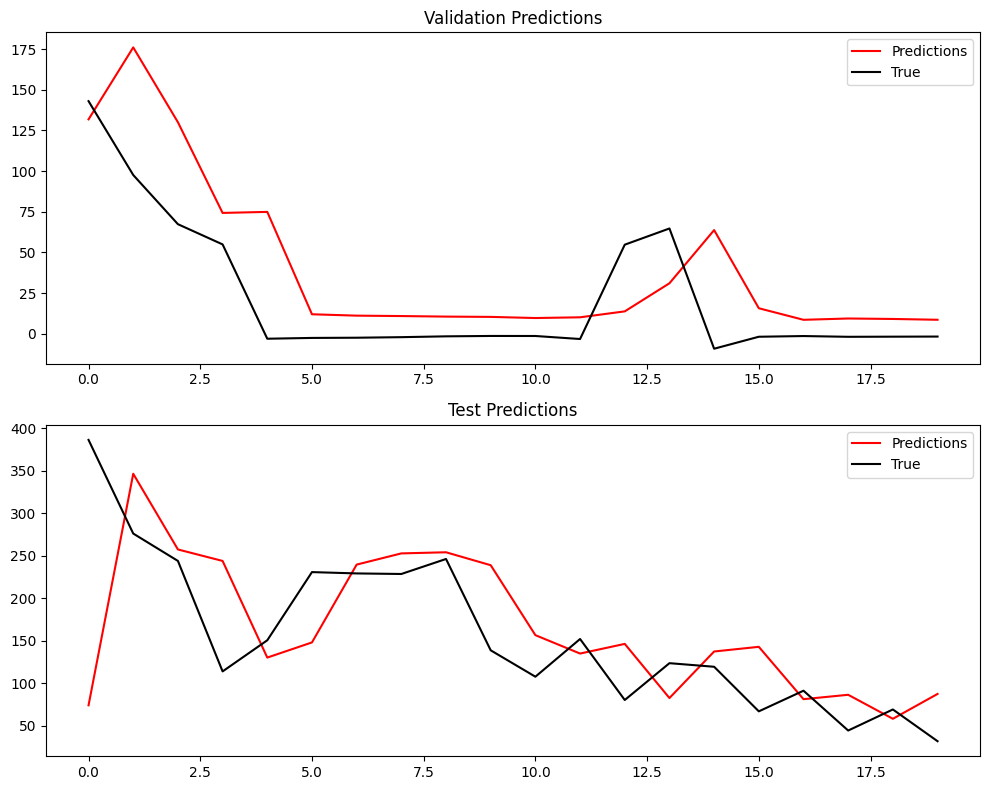

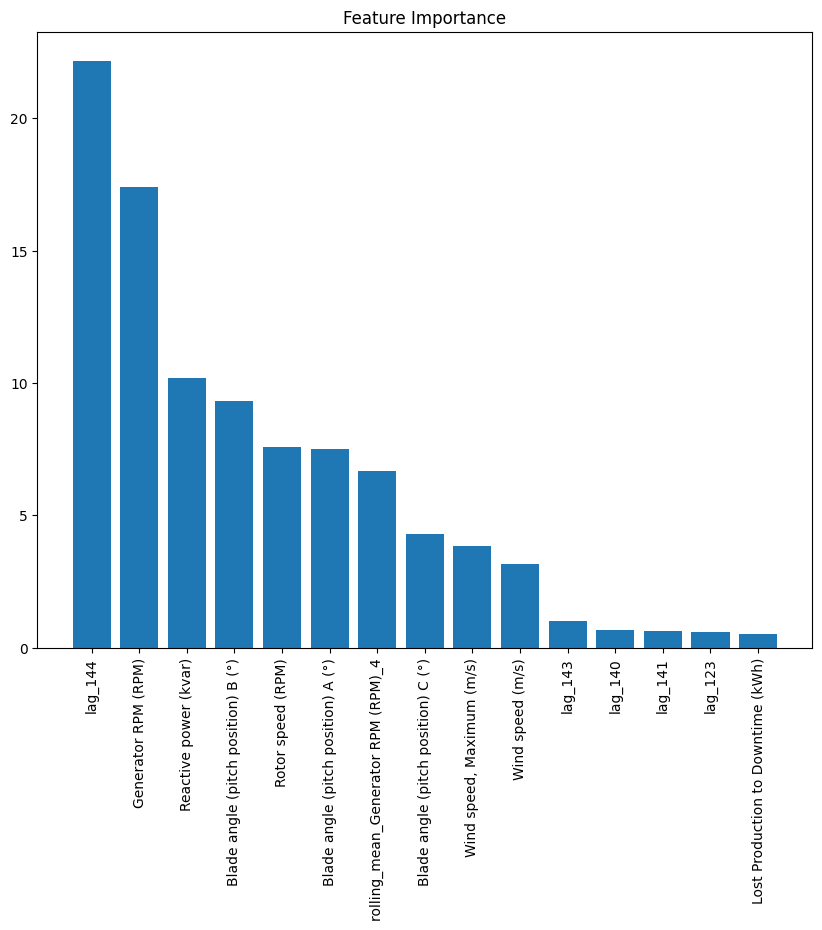

In [12]:
next_step_os,_=model.model_summarizer(val_x, val_y, test_x, test_y, plots=True,
plot_steps=20, feat_importance=True, feat_steps=15,feat_names=columns)



## Next Hour One shot Prediction



In [13]:
horizon = 6
window = 144
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                              window, horizon,target_col = 'Power (kW)',test_split= 0.5)

In [14]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1],multioutput=False) # we need to predict last step hence take the last element of y values

Learning rate set to 0.090134
0:	learn: 664.9460902	test: 624.2717386	best: 624.2717386 (0)	total: 105ms	remaining: 1m 44s
500:	learn: 219.4242566	test: 294.1102934	best: 269.5546583 (59)	total: 14.3s	remaining: 14.3s
999:	learn: 196.8078843	test: 306.7071579	best: 269.5546583 (59)	total: 27.5s	remaining: 0us
bestTest = 269.5546583
bestIteration = 59
Shrink model to first 60 iterations.


                   MAE        RMSE        R2
Validation  192.297868  269.554636  0.839121
Test        181.811042  259.705622  0.862493


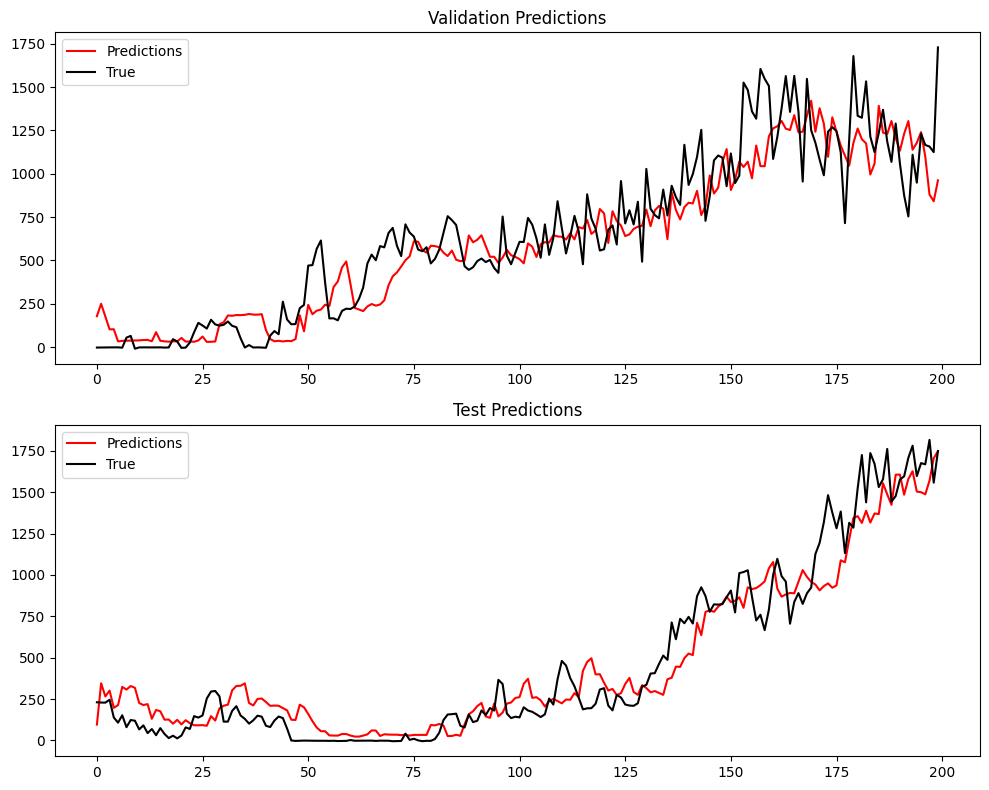

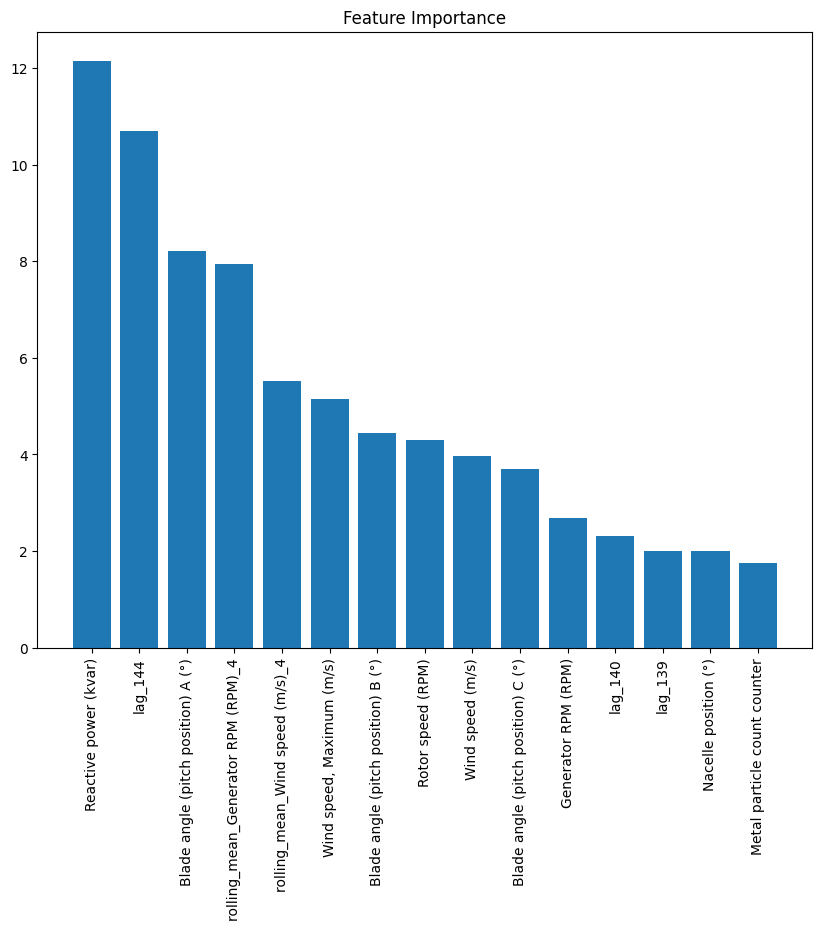

In [15]:
next_hour_os,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=200, feat_importance=True, feat_steps=15,feat_names= columns)



## Next Hour Recursive Prediction



In [16]:
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     144, 6,target_col ='Power (kW)',test_split = 0.5,univariate= True)

In [17]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"},prediction_type = 'recursive')
model.train(train_x, train_y[:,0], val_x, val_y[:,0],multioutput=False)

Learning rate set to 0.090134
0:	learn: 658.4494355	test: 617.2782679	best: 617.2782679 (0)	total: 42.8ms	remaining: 42.8s
500:	learn: 139.6772030	test: 149.8694212	best: 149.8198627 (454)	total: 9.92s	remaining: 9.88s
999:	learn: 132.9468105	test: 150.2838612	best: 149.8198627 (454)	total: 21.5s	remaining: 0us
bestTest = 149.8198627
bestIteration = 454
Shrink model to first 455 iterations.


                   MAE        RMSE       R2
Validation  112.207089  162.813926  0.94125
Test        110.561732  163.066366  0.94577


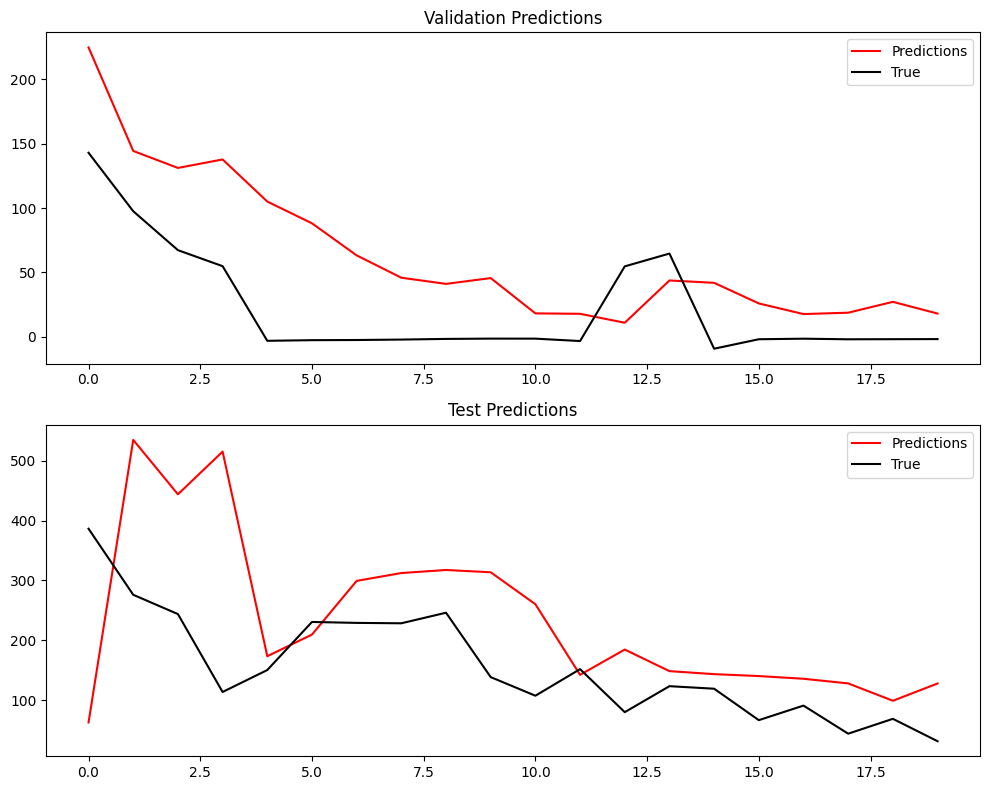

In [26]:
next_hour_rec,_=model.model_summarizer(val_x, val_y[:,0], test_x, test_y[:,0], plots=True,
plot_steps=20, feat_importance=False, feat_steps=15,feat_names= columns,horizon =6)



## Next Day One Shot Prediction



In [19]:
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     144, 144,target_col ='Power (kW)',test_split= 0.5)

In [20]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"})
model.train(train_x, train_y[:,-1], val_x, val_y[:,-1], multioutput= False)

Learning rate set to 0.090092
0:	learn: 696.5401171	test: 663.9556726	best: 663.9556726 (0)	total: 102ms	remaining: 1m 42s
500:	learn: 301.9588301	test: 768.7377932	best: 630.3998479 (19)	total: 15.5s	remaining: 15.4s
999:	learn: 245.4025323	test: 793.8213749	best: 630.3998479 (19)	total: 29.8s	remaining: 0us
bestTest = 630.3998479
bestIteration = 19
Shrink model to first 20 iterations.


                   MAE        RMSE        R2
Validation  534.902274  630.399863  0.123059
Test        489.390653  583.405266  0.306336


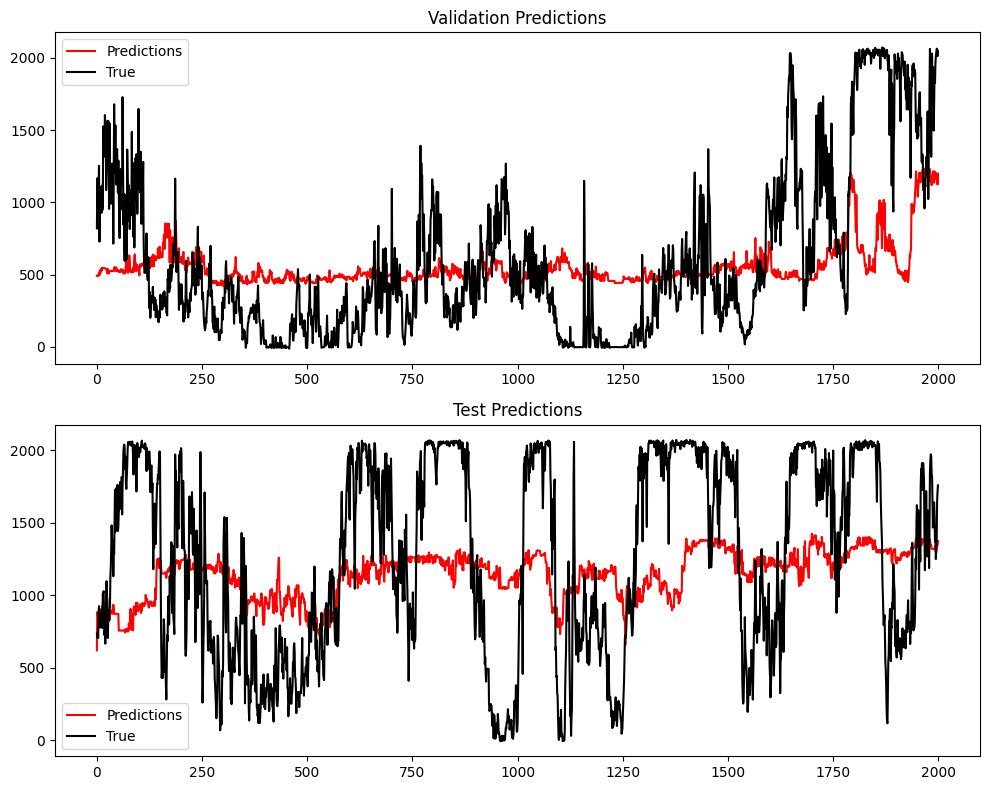

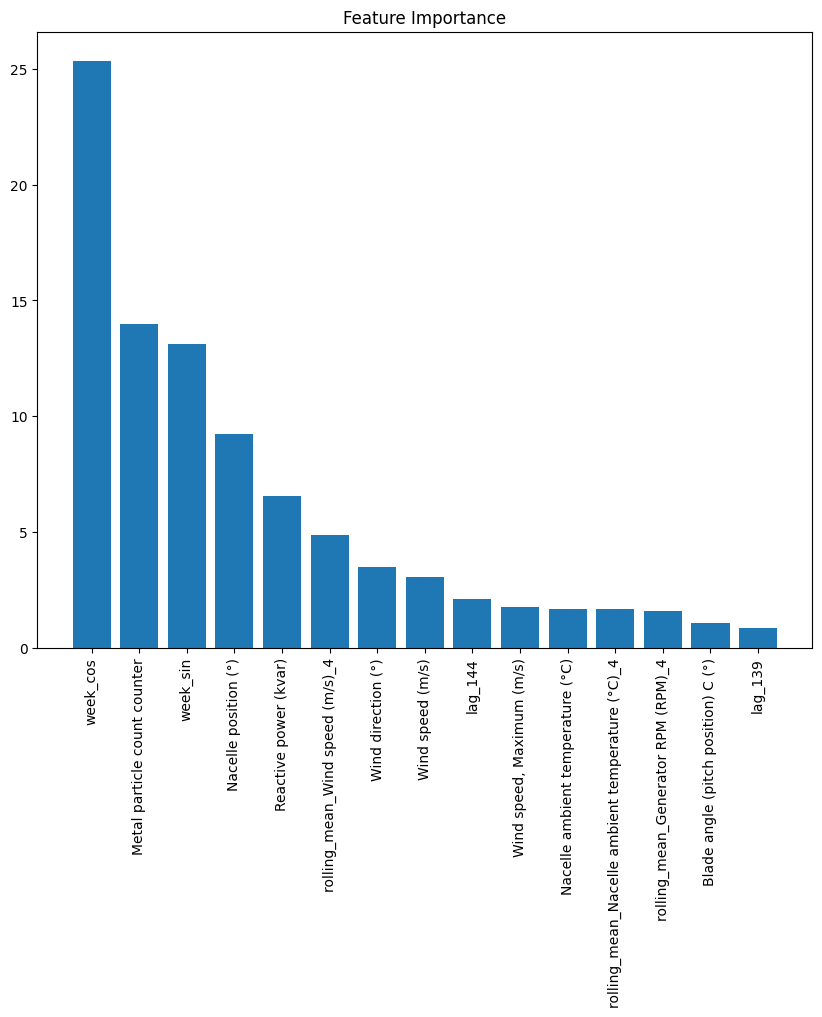

In [21]:
next_day_os,_=model.model_summarizer(val_x, val_y[:,-1], test_x, test_y[:,-1], plots=True,
plot_steps=2000, feat_importance=True, feat_steps=15,feat_names= columns)



## Next Day Recursive Prediction



In [22]:
train_x,val_x, test_x, train_y,val_y, test_y,columns =dataset.create_dataset(dataset.df,
                                                                     144, 144,target_col ='Power (kW)',test_split= 0.5,univariate=True)

In [23]:
model = Model('cb',{'thread_count':-1,'task_type':"GPU"},prediction_type = 'recursive')
model.train(train_x, train_y[:,0], val_x, val_y[:,0], multioutput= False)

Learning rate set to 0.090092
0:	learn: 658.5321963	test: 617.0204855	best: 617.0204855 (0)	total: 34.3ms	remaining: 34.2s
500:	learn: 140.0094092	test: 150.2937703	best: 150.1852392 (246)	total: 11.5s	remaining: 11.5s
999:	learn: 133.6489711	test: 150.6516504	best: 150.1852392 (246)	total: 21.2s	remaining: 0us
bestTest = 150.1852392
bestIteration = 246
Shrink model to first 247 iterations.


                   MAE        RMSE        R2
Validation  156.595045  219.332072  0.893382
Test        169.748817  242.492373  0.880075


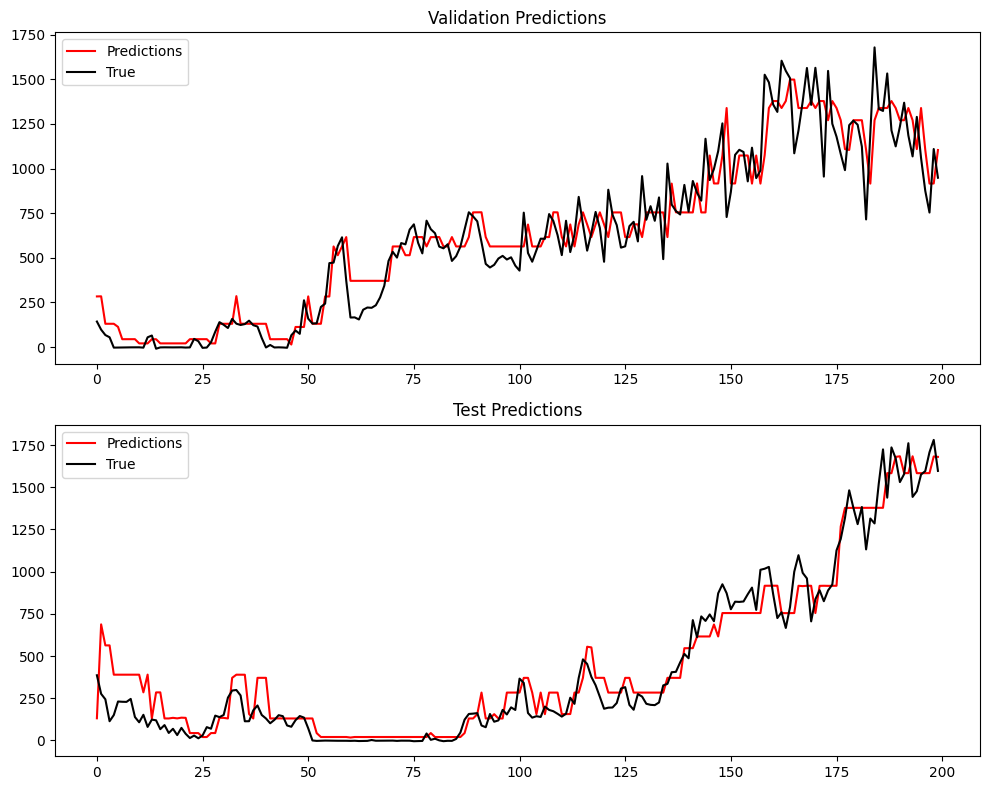

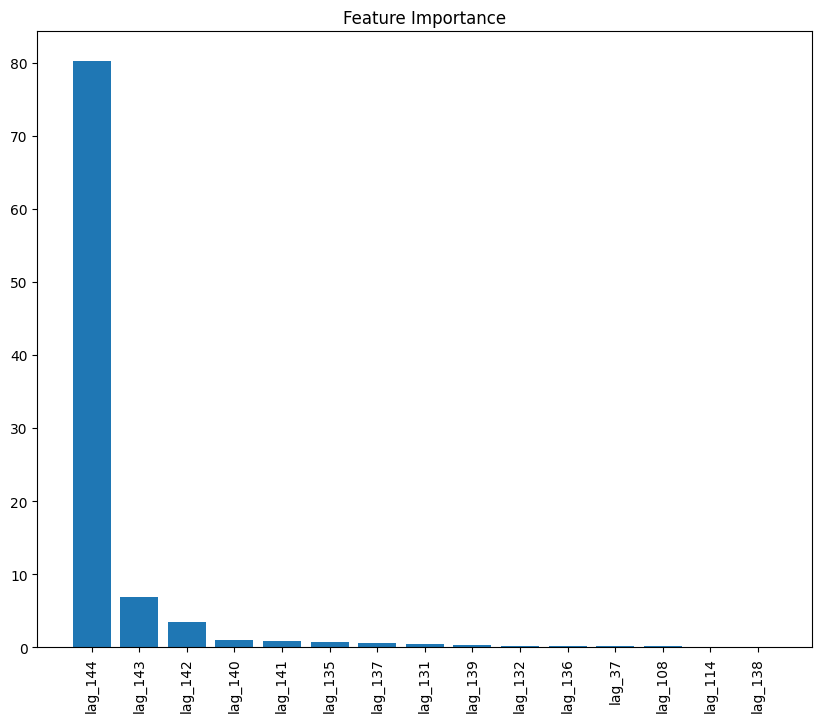

In [24]:
next_day_rec,_=model.model_summarizer(val_x, val_y[:,0], test_x, test_y[:,0], plots=True,
plot_steps=200, feat_importance=True, feat_steps=15,feat_names= columns,horizon =144)

# Result Comparison

In [27]:
from tabulate import tabulate

results = [next_step_os.iloc[1,:],next_hour_os.iloc[1,:],next_day_os.iloc[1,:],
           next_hour_rec.iloc[1,:],next_day_rec.iloc[1,:]]

names = ['Next Step One Shot', 'Next Hour One Shot', 'Next Day One Shot',
         'Next Hour Recursive', 'Next Day Recursive']
metrics = ['MAE', 'RMSE', 'R2']

header = ['Metric'] + metrics
table_data = []

# Append MAE, RMSE, and R2 values for the test set

for i,n in enumerate(names):
  value = [n] + [results[i]['MAE']] + [results[i]['RMSE']]+ [results[i]['R2']]
  table_data.append(value)
table = tabulate(table_data, headers=header, tablefmt='pipe')
print(table)

| Metric              |      MAE |    RMSE |       R2 |
|:--------------------|---------:|--------:|---------:|
| Next Step One Shot  |  97.3484 | 147.967 | 0.955362 |
| Next Hour One Shot  | 181.811  | 259.706 | 0.862493 |
| Next Day One Shot   | 489.391  | 583.405 | 0.306336 |
| Next Hour Recursive | 110.562  | 163.066 | 0.94577  |
| Next Day Recursive  | 169.749  | 242.492 | 0.880075 |
